Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=[7 2 1 ... 4 5 6]


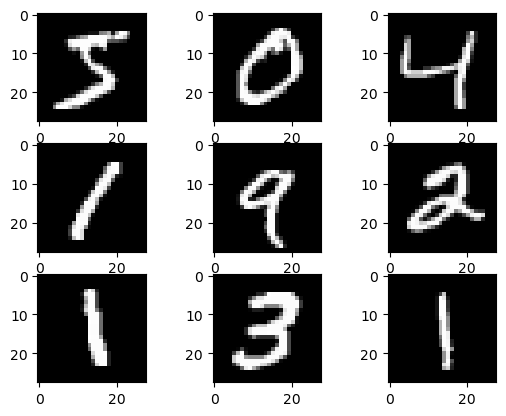

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,Dense

# download dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0


# summarize loaded dataset
print('Train: X=%s, y=%s' % (train_images.shape,train_labels.shape))
print('Test: X=%s, y=%s' % (test_images.shape,  test_labels))
# plot first 9 figure
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(train_images[i], cmap=plt.get_cmap('gray'))


In [16]:
def cross_validation(create_model_function):
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    fold = 1
    val_losses = []
    val_accuracies = []
    train_losses = []
    train_accuracies = []
    acc=[]

    for train_index, val_index in kf.split(train_images):
        print(f"Training fold {fold}")
        train_images_fold, val_images_fold = train_images[train_index], train_images[val_index]
        train_labels_fold, val_labels_fold = train_labels[train_index], train_labels[val_index]

        cnn_model = create_cnn_model2()
        history = cnn_model.fit(train_images_fold, train_labels_fold, epochs=5, validation_data=(val_images_fold, val_labels_fold))

        val_loss, val_accuracy = cnn_model.evaluate(val_images_fold, val_labels_fold)
        val_losses.append(history.history['val_loss'])
        val_accuracies.append(history.history['val_accuracy'])
        train_losses.append(history.history['loss'])
        train_accuracies.append(history.history['accuracy'])
        acc.append(val_accuracy)
        fold += 1
    #Draw a line chart of accuracy and loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    for i in range(5):
        plt.plot(val_losses[i], color="b")
        plt.plot(train_losses[i], color="r" )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.subplot(1, 3, 2)
    for i in range(5):
        plt.plot(val_accuracies[i],  color="b")
        plt.plot(train_accuracies[i], color="r")
    plt.plot( 1, color="b",label="validation")
    plt.plot( 1, color="r",label="train")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')

    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.subplot(1, 3, 3)
    plt.boxplot(acc)
    plt.title('Validation Accuracy for Each Fold')
    plt.xticks([1], ['Cross-validation'])
    plt.ylabel('Accuracy')
    plt.show()

Training fold 1
Epoch 1/5
1500/1500 [==============================] - 74s 49ms/step - loss: 0.1359 - accuracy: 0.9583 - val_loss: 0.0707 - val_accuracy: 0.9785
Epoch 2/5
1500/1500 [==============================] - 55s 37ms/step - loss: 0.0429 - accuracy: 0.9867 - val_loss: 0.0520 - val_accuracy: 0.9851
Epoch 3/5
1500/1500 [==============================] - 70s 47ms/step - loss: 0.0279 - accuracy: 0.9911 - val_loss: 0.0474 - val_accuracy: 0.9858
Epoch 4/5
1500/1500 [==============================] - 75s 50ms/step - loss: 0.0198 - accuracy: 0.9933 - val_loss: 0.0505 - val_accuracy: 0.9866
Epoch 5/5
375/375 [==============================] - 12s 33ms/step - loss: 0.0536 - accuracy: 0.9865
Training fold 2
Epoch 1/5
1500/1500 [==============================] - 62s 41ms/step - loss: 0.1379 - accuracy: 0.9574 - val_loss: 0.0632 - val_accuracy: 0.9797
Epoch 2/5
1500/1500 [==============================] - 47s 31ms/step - loss: 0.0442 - accuracy: 0.9862 - val_loss: 0.0532 - val_accuracy: 0.98

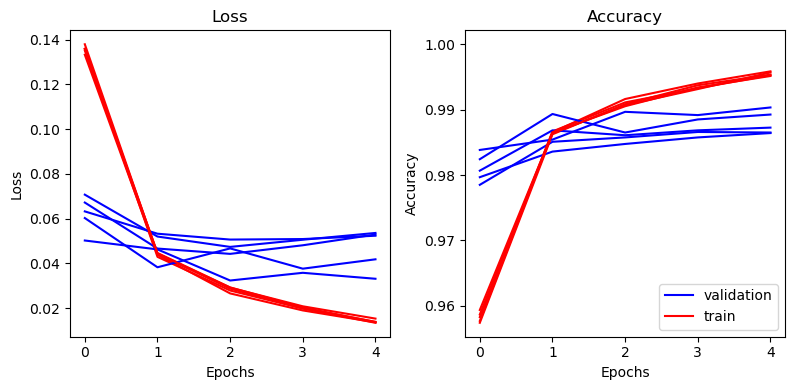

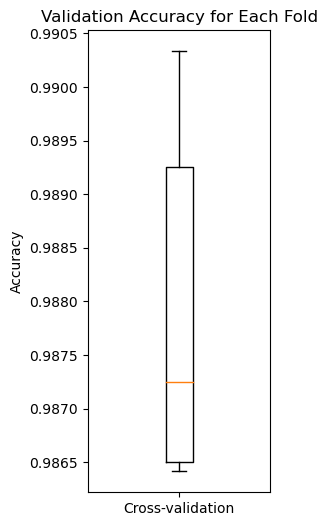

In [17]:
# build baseline
def create_cnn_model(filters=32, kernel_size=(3, 3), pool_size=(2, 2), dense_units=64, learning_rate=0.001):
    model = Sequential()
    model.add(Conv2D(filters, kernel_size, activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    # 编译模型，使用传入的学习率
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
cross_validation(create_cnn_model)


In [18]:
model = KerasClassifier(create_cnn_model, verbose=0)
param_grid = {
    'filters': [32, 64],
    'kernel_size': [(3, 3), (5, 5)],
    'pool_size': [(2, 2), (3, 3)],
    'dense_units': [64, 128],
    'learning_rate': [0.001, 0.01]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search_result = grid_search.fit(train_images, train_labels)

print("Best: %f using %s" % (grid_search_result.best_score_, grid_search_result.best_params_))

C:\Windows\Temp\ipykernel_9520\2700922874.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(create_cnn_model, verbose=0)


Best: 0.980717 using {'dense_units': 128, 'filters': 64, 'kernel_size': (5, 5), 'learning_rate': 0.001, 'pool_size': (3, 3)}


In [19]:

def model1():
    model = models.Sequential([
        layers.Conv2D(64, (5,5), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((3, 3)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((3, 3)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Training fold 1
Epoch 1/5
1500/1500 [==============================] - 72s 48ms/step - loss: 0.1343 - accuracy: 0.9587 - val_loss: 0.0649 - val_accuracy: 0.9802
Epoch 2/5
1500/1500 [==============================] - 71s 48ms/step - loss: 0.0407 - accuracy: 0.9875 - val_loss: 0.0508 - val_accuracy: 0.9835
Epoch 3/5
1500/1500 [==============================] - 72s 48ms/step - loss: 0.0260 - accuracy: 0.9919 - val_loss: 0.0541 - val_accuracy: 0.9842
Epoch 4/5
1500/1500 [==============================] - 71s 48ms/step - loss: 0.0193 - accuracy: 0.9936 - val_loss: 0.0580 - val_accuracy: 0.9829
Epoch 5/5
375/375 [==============================] - 13s 33ms/step - loss: 0.0421 - accuracy: 0.9883
Training fold 2
Epoch 1/5
1500/1500 [==============================] - 70s 47ms/step - loss: 0.1335 - accuracy: 0.9592 - val_loss: 0.0565 - val_accuracy: 0.9828
Epoch 2/5
1500/1500 [==============================] - 69s 46ms/step - loss: 0.0433 - accuracy: 0.9863 - val_loss: 0.0478 - val_accuracy: 0.98

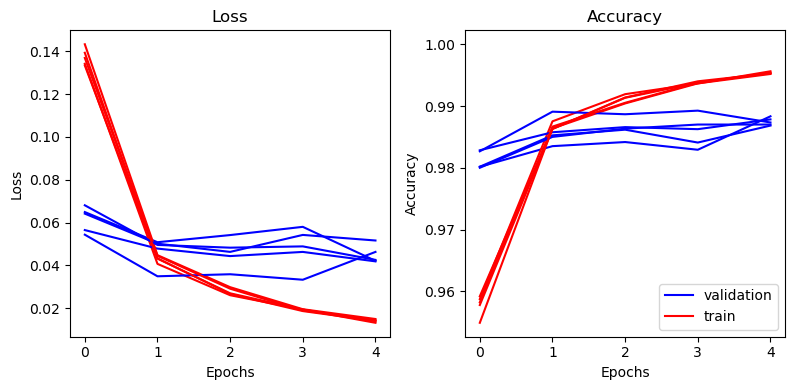

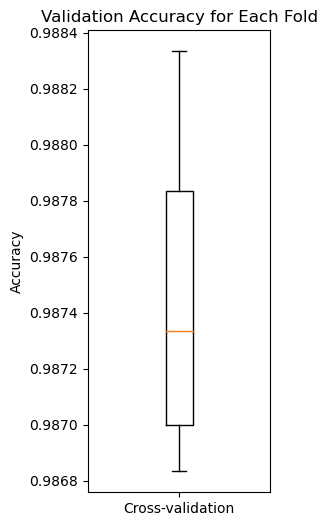

In [20]:
cross_validation(model1)

In [24]:

def model2():
    model = models.Sequential([
        layers.Conv2D(64, (5, 5), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((3, 3)),
        layers.Conv2D(64, (5, 5), activation='relu'),
        BatchNormalization(),
        layers.MaxPooling2D((3, 3)),
        layers.Conv2D(64, (5, 5), activation='relu'),
        BatchNormalization(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


Training fold 1
Epoch 1/5
1500/1500 [==============================] - 67s 45ms/step - loss: 0.1395 - accuracy: 0.9573 - val_loss: 0.0577 - val_accuracy: 0.9824
Epoch 2/5
1500/1500 [==============================] - 49s 32ms/step - loss: 0.0445 - accuracy: 0.9863 - val_loss: 0.0579 - val_accuracy: 0.9815
Epoch 3/5
1500/1500 [==============================] - 48s 32ms/step - loss: 0.0282 - accuracy: 0.9912 - val_loss: 0.0500 - val_accuracy: 0.9857
Epoch 4/5
1500/1500 [==============================] - 46s 31ms/step - loss: 0.0199 - accuracy: 0.9934 - val_loss: 0.0555 - val_accuracy: 0.9854
Epoch 5/5
375/375 [==============================] - 9s 23ms/step - loss: 0.0523 - accuracy: 0.9863
Training fold 2
Epoch 1/5
1500/1500 [==============================] - 48s 32ms/step - loss: 0.1367 - accuracy: 0.9580 - val_loss: 0.0655 - val_accuracy: 0.9799
Epoch 2/5
1500/1500 [==============================] - 51s 34ms/step - loss: 0.0431 - accuracy: 0.9864 - val_loss: 0.0563 - val_accuracy: 0.983

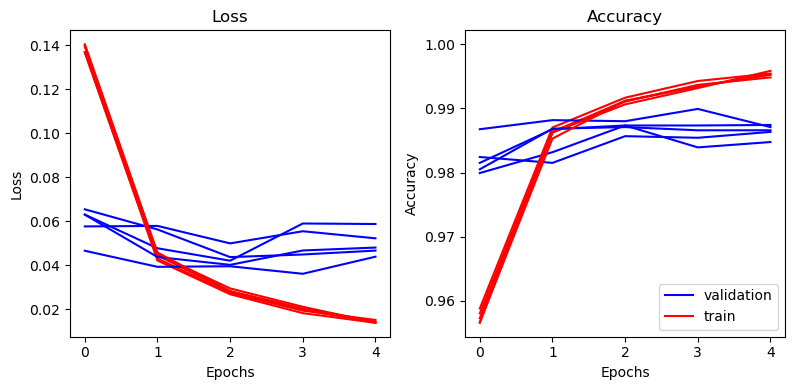

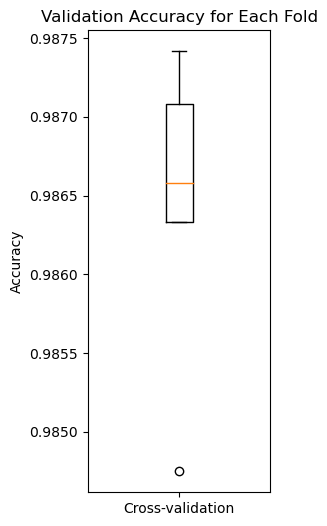

In [25]:
cross_validation(model2)